### Importar las librerias

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
import tensorflow as tf
from skimage.color import rgb2gray
%matplotlib inline
import os
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import rescale
from PIL import Image, ImageOps
import json
import pickle

### Importar el dataset desde Github

In [2]:
# Acceder a repo de Github
! rm -rf dataset-food
! rm -f pickle_imagenes0
! rm -f pickle_imagenes1
! rm -f pickle_imagenes2
! rm -f pickle_imagenes3
! rm -f pickle_imagenes4
! rm -f pickle_imagenes5
! rm -f pickle_imagenes6
! rm -f pickle_imagenes7
! rm -f pickle_imagenes8
! rm -f pickle_imagenes9
! rm -f pickle_imagenes10
! rm -f pickle_jsons
! git clone https://github.com/brokenerk/dataset-food.git
! ls

Cloning into 'dataset-food'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 3331 (delta 92), reused 103 (delta 46), pack-reused 3142
Receiving objects: 100% (3331/3331), 777.37 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (192/192), done.
Checking out files: 100% (2704/2704), done.
dataset-food  sample_data


### Clases y cantidad de imágenes por cada una
#### Resumen del dataset

In [3]:
path = './dataset-food/'
classes = []
jsons = []
for f in os.listdir(path):
  if(f != "README.md" and f != ".git"):
    classes.append(f)
classes.sort()

print("Total clases: " + str(len(classes)))
print("Cantidad de imagenes por platillo\n")

for f in classes:
  imagenes = os.listdir(path + f)
  for i in imagenes:
    if(i.find("json") != -1 or i.find("JSON") != -1):
      jsons.append(i)
    
  print(f + ": " + str(len(imagenes) - 1))
  del imagenes

jsons.sort()

Total clases: 53
Cantidad de imagenes por platillo

Birria: 50
BurritoArrachera: 50
CamaronesEmpanizadosAlCoco: 50
ChicharronPreparado: 50
ChongoZamorano: 50
CoctelCamaron: 50
ElotePreparado: 50
EnchiladasHuastecas: 50
EnchiladasVerdes: 50
GorditaChicharron: 50
Guacamole: 50
HuevosRancheros: 50
Milanesa: 50
Mixiote: 50
MojarraMojoAjo: 50
MoleDeOlla: 50
MolePoblano: 50
Molletes: 50
Pambazos: 50
Picadillo: 50
PicoGallo: 50
Pozol: 50
Pozole Verde: 50
QuesadillasDePollo: 50
Sopes: 50
TacosAlPastor: 50
TacosDorados: 50
TamalesOaxaqueños: 50
TampiqueñaRes: 50
Tlacoyos: 50
TortaAhogada: 50
Tostadas: 50
ajoComino: 50
arrozRojo: 50
chicharronSalsaVerde: 50
chilaquilesverdes: 50
chilesEnNogada: 50
chilesRellenos: 50
cochinitaPibil: 50
enfrijoladas: 50
esquites: 50
frijolesOlla: 50
huaraches: 50
huevosalamexicana: 50
panDeMuerto: 50
pastel azteca: 50
pechugaasada: 50
pescadoVeracruzana: 50
pozoleRojo: 50
romeritos: 50
tingaDePollo: 50
tlayudas: 50
verduras salteadas: 50


### Codificacion Onehot para las clases (platillos)
*   Conversión del vector onehot a arreglo de numpy y float32



In [4]:
# Onehot encode
classes_onehot = np.array(classes)
onehot_encoder = OneHotEncoder(sparse = False)
classes_onehot = classes_onehot.reshape(len(classes_onehot), 1)
classes_onehot = onehot_encoder.fit_transform(classes_onehot).astype('float32')

classes_onehot.shape

(53, 53)

### Data Augmentation
Las variantes que se generan por cada imágen válida ya preprocesada son:

*   Volteada a la izquierda (espejo)
*   Volteada de cabeza
*   Volteada de cabeza espejo (volteada a la izquierda)
*   Saturación de color a todas las anteriores (3)
*   Saturación de color a la imágen original

Dando un total de 7 variaciones por imágen, más la imágen preprocesada original (8 en total)

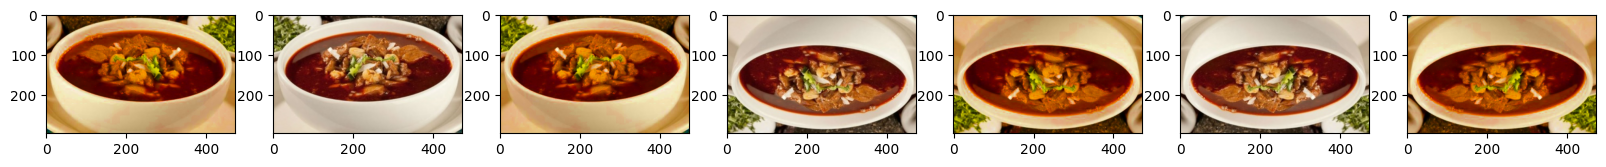

In [10]:
def dataAugmentation(img):
  # Se revisan los canales para RGB
  canales = img.getbands()
  image = np.array(img.convert('RGB'))
  if(len(canales) > 3):
    image = image[:, :, 0:3]

  da = []
  
  saturated1 = tf.image.adjust_saturation(image, 3)
  da.append(saturated1)

  flip_left = tf.image.flip_left_right(image)

  rotated90 = tf.image.rot90(image)
  flip_left_rotated90 = tf.image.flip_left_right(rotated90)

  flip_up = tf.image.rot90(rotated90)
  flip_left_up = tf.image.flip_left_right(flip_up)

  da.append(flip_left)
  saturated7 = tf.image.adjust_saturation(flip_left, 3)
  da.append(saturated7)

  #da.append(rotated90)
  saturated8 = tf.image.adjust_saturation(rotated90, 3)
  #da.append(saturated8)
  
  #da.append(flip_left_rotated90)
  saturated9 = tf.image.adjust_saturation(flip_left_rotated90, 3)
  #da.append(saturated9)

  da.append(flip_up)
  saturated10 = tf.image.adjust_saturation(flip_up, 3)
  da.append(saturated10)

  da.append(flip_left_up)
  saturated11 = tf.image.adjust_saturation(flip_left_up, 3)
  da.append(saturated11)

  return da

img = Image.open(path + "/Birria/Birria01.jpg")
dataAug = dataAugmentation(img)
fig, axes = plt.subplots(nrows = 1, ncols = 7, figsize = (20, 4), dpi = 100)
cont = 0

for da in dataAug:
  da = da.numpy()
  axes[cont].imshow(da)
  cont += 1

### Preprocesamiento de imágenes y JSON

*   Dimensiones de la imágen
*   Lectura de JSONS
*   Revisión de canales de color para RGB
*   Aplicación de proporcion rectangular o cuadrada
*   Las imagenes se REESCALAN a un tamaño de 300x300
*   Aplicación de filtros: escala de grises y bordes como canales adicionales
*   Aplicacion de data augmentation
*   Manejo de archivos corruptos (json e imágenes)

In [0]:
def getDimensions(folder, imagenes, proporcion):
  if(proporcion):
    # Rectangular
    width = 640
    height = 448
  else:
    # Cuadrado
    width = 448
    height = 448
    
  return (width, height)

In [0]:
def preprocesarImagen(folder, imagenes, proporcion, cont, rgb, escalaGrises, bordes, applyDataAugmentation):
  preprocessed = []
  width, height = getDimensions(folder, imagenes, proporcion)

  for i in imagenes:
    # Lectura del JSON
    if(i.find("json") != -1 or i.find("JSON") != -1):
      try:
        with open(path + folder + '/' + i, encoding = "utf-8") as json_file: 
          dict = json.load(json_file)
          receta = [classes_onehot[cont], dict]
          listaIngredientes.append(receta)
        continue
      except:
        print("Error al leer JSON " + i + ". Ignorando..")
        continue
    
    # Lectura de la imagen
    try:
      img = Image.open(path + folder + '/' + i)
    except:
        print("Imagen corrupta, ignorando: " + i)
        continue
    
    w, h = img.size
    
    w_pixels = abs(w - width)
    h_pixels = abs(h - height)

    # Se aplica la proporcion rectangular o cuadrada
    if(h < height and w < width):
      border = (int(w_pixels / 2), int(h_pixels / 2), int(w_pixels / 2), int(h_pixels / 2))
      img = ImageOps.expand(img, border)
    elif(h < height and w > width):
      border = (int(w_pixels / 2), 0, int(w_pixels / 2), 0)
      img = ImageOps.crop(img, border)
      border = (0, int(h_pixels / 2), 0, int(h_pixels / 2))
      img = ImageOps.expand(img, border)
    elif(h > height and w < width):
      border = (int(w_pixels / 2), 0, int(w_pixels / 2), 0)
      img = ImageOps.expand(img, border)
      border = (0, int(h_pixels / 2), 0, int(h_pixels / 2))
      img = ImageOps.crop(img, border)
    elif(h > height and w > width):
      border = (int(w_pixels / 2), int(h_pixels / 2), int(w_pixels / 2), int(h_pixels / 2))
      img = ImageOps.crop(img, border)

    # Se hace una segunda revision para eliminar pixeles extras, resultantes de la division 
    # entre 2 de ancho y alto (en numeros nones, por ejemplo, la division no es proporcional)
    w, h = img.size
    w_pixels = w - width
    h_pixels = h - height

    border = (abs(w_pixels), 0, 0, 0)
    if(w_pixels > 0):
      img = ImageOps.crop(img, border)
    elif (w_pixels < 0):
      img = ImageOps.expand(img, border)

    border = (0, abs(h_pixels), 0, 0)
    if(h_pixels > 0):
      img = ImageOps.crop(img, border)
    elif (h_pixels < 0):
      img = ImageOps.expand(img, border)

    # Data Augmentation
    da = [img]
    if(applyDataAugmentation):
      da = da + dataAugmentation(img)

    k = 0
    for d in da:
      if(k != 0):
        img = Image.fromarray(d.numpy(), 'RGB')
      else:
        img = d

      # Se revisan los canales para RGB
      canales = img.getbands()

      AImgRGB = np.array(img.convert('RGB'))
      if(len(canales) > 3):
        AImgRGB = AImgRGB[:, :, 0:3]

      # Se reescala la imagen para que sea mas pequeña
      # sin perder proporcion ni calidad
      AImgRGB = AImgRGB.reshape((int(height / 4), 4, int(width / 4), 4, 3)).max(3).max(1)
      AImg = None

      # RGB
      if(rgb):
        AImg = AImgRGB

      # Se aplican y agregan filtros como canales extras
      filtro1 = np.array(img.convert('L'))
      filtro1 = rescale(filtro1, 1 / 4, anti_aliasing = True)
      filtro1 = filtro1.reshape(int(height / 4), int(width / 4))

      # Escala de grises
      if(escalaGrises):
        if(isinstance(AImg, np.ndarray)):
          AImg = np.dstack((AImg, filtro1))
        else:
          AImg = filtro1

      # Bordes
      if(bordes):
        filtro2 = feature.canny(filtro1)
        filtro2 = filtro2.reshape(int(height / 4), int(width / 4))
        if(isinstance(AImg, np.ndarray)):
          AImg = np.dstack((AImg, filtro2))
        else:
          AImg = filtro2

      preprocessed.append(AImg)
      img.close()
      k += 1

  return preprocessed

### Preparación y serialización de los datos 

*   Selección de proporcion. Rectangular = True. Cuadrado = False.
*   Selección de filtros
*   Selección de data augmentation
*   Normalización de las imágenes
*   Conversión de imágenes a arreglos de numpy y float32
*   Generación de lista imágen + clase onehot
*   Generación de lista clase onehot + JSON (dicccionario)
*   Generación de pickles de imágen + clase onehot menores a 2GB

In [27]:
listaPlatillos = []
listaIngredientes = []
rgb = True
escalaGrises = True
bordes = True
proporcion = True # Rectangular = True. Cuadrado = False
applyDataAugmentation = True
index = 0
cont = 0
batch = 15

if(proporcion):
  print("Proporcion RECTANGULAR")
else:
  print("Proporcion CUADRADA")

# Recorre todas las clases
for c in classes:
  # Obtiene las imagenes y JSON de cada clase
  imagenes = os.listdir(path + c)
  imagenes.sort()
  # Preprocesamiento de los archivos
  preprocessed = preprocesarImagen(c, imagenes, proporcion, index, rgb, escalaGrises, bordes, applyDataAugmentation)
  del imagenes

  # Se recorren las imagenes de la clase pre procesadas
  for p in preprocessed:
    # Se normaliza y se convierte a float32 cada imagen
    p = p.astype('float32') / 255.0
    # Se agrega la imagen y su clase onehot
    platillo = [p, classes_onehot[index]]
    listaPlatillos.append(platillo)
    tam = p.shape
  
  print(str(index) + " " + c + " Imagenes total: " + str(len(preprocessed)) + " Tam: " + str(tam))

  # Se van guardando las imagenes en archivos pickles
  # por partes, segun el tam de batch
  if(index == len(classes) - 1):
    f = open('pickle_imagenes' + str(cont), 'wb')
    print("Escribiendo pickle " + str(cont))
    pickle.dump(listaPlatillos, f)
    f.close()
    listaPlatillos.clear()
    cont += 1

   # Ultima parte en pickle
  if((index + 1) % batch == 0 and cont < int((len(classes) / batch))):
    f = open('pickle_imagenes' + str(cont), 'wb')
    print("Escribiendo pickle " + str(cont))
    pickle.dump(listaPlatillos, f)
    f.close()
    listaPlatillos.clear()
    cont += 1
  index += 1

del listaPlatillos

Proporcion RECTANGULAR
0 Birria Imagenes total: 400 Tam: (112, 160, 5)
1 BurritoArrachera Imagenes total: 400 Tam: (112, 160, 5)
2 CamaronesEmpanizadosAlCoco Imagenes total: 400 Tam: (112, 160, 5)
3 ChicharronPreparado Imagenes total: 400 Tam: (112, 160, 5)
4 ChongoZamorano Imagenes total: 400 Tam: (112, 160, 5)


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


5 CoctelCamaron Imagenes total: 400 Tam: (112, 160, 5)
6 ElotePreparado Imagenes total: 400 Tam: (112, 160, 5)
7 EnchiladasHuastecas Imagenes total: 400 Tam: (112, 160, 5)
8 EnchiladasVerdes Imagenes total: 400 Tam: (112, 160, 5)
9 GorditaChicharron Imagenes total: 400 Tam: (112, 160, 5)
10 Guacamole Imagenes total: 400 Tam: (112, 160, 5)
11 HuevosRancheros Imagenes total: 400 Tam: (112, 160, 5)
12 Milanesa Imagenes total: 400 Tam: (112, 160, 5)
13 Mixiote Imagenes total: 400 Tam: (112, 160, 5)
14 MojarraMojoAjo Imagenes total: 400 Tam: (112, 160, 5)
Escribiendo pickle 0
15 MoleDeOlla Imagenes total: 400 Tam: (112, 160, 5)
16 MolePoblano Imagenes total: 400 Tam: (112, 160, 5)
17 Molletes Imagenes total: 400 Tam: (112, 160, 5)
18 Pambazos Imagenes total: 400 Tam: (112, 160, 5)
19 Picadillo Imagenes total: 400 Tam: (112, 160, 5)
20 PicoGallo Imagenes total: 400 Tam: (112, 160, 5)
21 Pozol Imagenes total: 400 Tam: (112, 160, 5)
22 Pozole Verde Imagenes total: 400 Tam: (112, 160, 5)
23 Que

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


30 TortaAhogada Imagenes total: 400 Tam: (112, 160, 5)
31 Tostadas Imagenes total: 400 Tam: (112, 160, 5)
32 ajoComino Imagenes total: 400 Tam: (112, 160, 5)
33 arrozRojo Imagenes total: 400 Tam: (112, 160, 5)
34 chicharronSalsaVerde Imagenes total: 400 Tam: (112, 160, 5)
35 chilaquilesverdes Imagenes total: 400 Tam: (112, 160, 5)
36 chilesEnNogada Imagenes total: 400 Tam: (112, 160, 5)
37 chilesRellenos Imagenes total: 400 Tam: (112, 160, 5)
38 cochinitaPibil Imagenes total: 400 Tam: (112, 160, 5)
39 enfrijoladas Imagenes total: 400 Tam: (112, 160, 5)
40 esquites Imagenes total: 400 Tam: (112, 160, 5)
41 frijolesOlla Imagenes total: 400 Tam: (112, 160, 5)
42 huaraches Imagenes total: 400 Tam: (112, 160, 5)
43 huevosalamexicana Imagenes total: 400 Tam: (112, 160, 5)
44 panDeMuerto Imagenes total: 400 Tam: (112, 160, 5)
Escribiendo pickle 2
45 pastel azteca Imagenes total: 400 Tam: (112, 160, 5)
46 pechugaasada Imagenes total: 400 Tam: (112, 160, 5)
47 pescadoVeracruzana Imagenes total:

##### En total los datos se dividen en 53 clases (platillos)

##### Cada clase posee 50 imágenes. Un total de 2650 imágenes.

##### Si se aplica data augmentation, cada clase posee 400 imágenes. Un total de 21200 imágenes.

##### El numero de canales depende de los filtros aplicados.

##### Si se deja solo en RGB, son 3. 
##### Si se aplican los filtros de escala de grises y deteccion de bordes, son 5.


*   Generación de pickle de clase + JSON menor a 2GB

In [28]:
f = open('pickle_jsons', 'wb')
print("Escribiendo pickle jsons")
pickle.dump(listaIngredientes, f)
f.close()
del listaIngredientes

!ls

Escribiendo pickle jsons
dataset-food	  pickle_imagenes1  pickle_imagenes3  sample_data
pickle_imagenes0  pickle_imagenes2  pickle_jsons


### Lectura de archivos serializados pickles
Se leen los archivos pickles generados para comprobar que todo este en orden.

In [30]:
listaPlatillos = []
listaIngredientes = []

for j in range(0, cont):
  f = open('pickle_imagenes' + str(j), 'rb')
  listaPlatillos= listaPlatillos + pickle.load(f, encoding='bytes')
  print("picke_imagenes" + str(j) + " leido");
  f.close()


f = open('pickle_jsons', 'rb')
listaIngredientes = pickle.load(f, encoding='bytes')
print("picke_jsons leido");
f.close()

picke_imagenes0 leido
picke_imagenes1 leido
picke_imagenes2 leido
picke_imagenes3 leido
picke_jsons leido


### Muestra de los datos preprocesados
Matriz de una imágen de un platillo junto a su clase onehot

In [38]:
listaPlatillos[0]

[array([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
    

Tamaño de la lista de platillos

In [39]:
len(listaPlatillos)

21200

#### Imagen a color RGB - 3 canales [Canales 0 - 2]

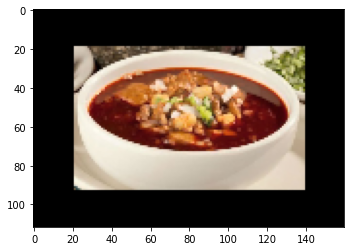

In [45]:
imagenMuestra = listaPlatillos[0][0]
plt.imshow(imagenMuestra[:, :, 0:3])

#### Imagen con filtro de escala de grises [Canal 3]

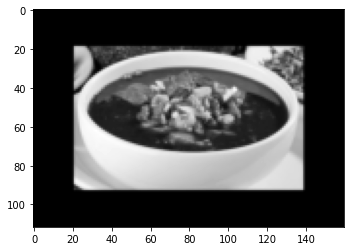

In [41]:
plt.imshow(imagenMuestra[:, :, 3], cmap='gray')

#### Imagen con filtro de bordes [Canal 4]

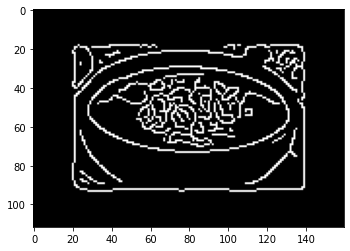

In [42]:
plt.imshow(imagenMuestra[:, :, 4], cmap='gray')

Los ingredientes del platillo seleccionado, a modo de diccionario, junto a su clase onehot

In [43]:
listaIngredientes[1]

[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=float32),
 {'BurritoArrachera': [{'Calorias': 1818,
    'Cantidad': '4',
    'Ingrediente': 'Harina de trigo'},
   {'Calorias': 0, 'Cantidad': '1/3', 'Ingrediente': 'Sal'},
   {'Calorias': 0, 'Cantidad': '2', 'Ingrediente': 'Polvo para hornear'},
   {'Calorias': 1824, 'Cantidad': '48', 'Ingrediente': 'Manteca vegetal'},
   {'Calorias': 2, 'Cantidad': '1', 'Ingrediente': 'Agua'},
   {'Calorias': 0, 'Cantidad': '1/3', 'Ingrediente': 'Sal'},
   {'Calorias': 300, 'Cantidad': '5.42', 'Ingrediente': 'Pancita de puerco'},
   {'Calorias': 96, 'Cantidad': '1', 'Ingrediente': 'Cebolla blanca rebanada'},
   {'Calorias': 72,
    'Cantidad': '1',
    'Ingrediente': 'Pimiento verde crudo chico'},
   {'Calorias': 72,
    'Cantidad': '1',
    'Ingrediente

Tamaño lista de Ingredientes por platillo 

In [37]:
len(listaIngredientes)

53